<H1><font color="lightgreen">Important Update</font></H1>

Due to the deprecation and incompatibility of CRF layers in the TensorFlow ecosystem, a BiLSTM + Softmax architecture (AS per TA) was implemented instead of BiLSTM + CRF. This approach performs token-level classification using sequence-aware contextual representations and is a widely accepted alternative for Named Entity Recognition.

<H1><font color="lightgreen">Problem Statement</font></H1>

Twitter generates an extremely high volume of unstructured textual data, with hundreds of millions of tweets posted daily. Relying solely on user-generated hashtags to understand trends and topics is unreliable due to inconsistency, noise, and missing tags. To address this, Twitter aims to implement Named Entity Recognition (NER) to automatically identify and classify entities such as people, organizations, and locations within tweets. This enables more accurate content tagging, improved trend analysis, and deeper insights into user conversations at scale.

<B>As a Data Scientist at Twitter</B>

From a Data Scientist’s standpoint at Twitter, this initiative delivers the following value:

> Scalable information extraction from high-volume, real-time tweet streams

> Improved trend detection beyond noisy or absent hashtags

> Structured insights from unstructured text, enabling better analytics and search

> Entity-level understanding of conversations (who, what, where)

Model comparison and optimization, leveraging:

> BiLSTM + CRF for sequential dependency learning

> Transformer-based models (BERT) for contextual understanding

End-to-end NLP pipeline development, including:

> Data preprocessing and annotation handling

> Model training and hyperparameter tuning

> Robust evaluation and prediction workflows

<B>Business impact:</B>
Accurate NER directly enhances content understanding, supports data-driven decision-making, and improves downstream applications such as trend analysis, recommendation systems, and targeted insights.

<H1><font color="lightgreen">Synopsis of the Dataset</font></H1>

In [ ]:
!pip install seqeval

In [ ]:
# Importing necessary library files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import keras_nlp
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from seqeval.metrics import classification_report, f1_score

In [ ]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

In [ ]:
# Defining a function to read a CoNLL file and displaying the last sentences
def read_conll_file(file_path):
    """
    Reads a CoNLL formatted file into a list of sentences.
    Each sentence is a list of token dictionaries.
    """
    sentences = []
    current_sentence = []

    def flush_sentence():
        """Append current sentence if not empty and reset."""
        if current_sentence:
            sentences.append(current_sentence.copy())
            current_sentence.clear()

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()

            # Skip comments
            if not line or line.startswith("#"):
                flush_sentence()
                continue

            parts = line.split("\t")

            # Defensive parsing (handles variable CoNLL formats)
            token = {
                "word": parts[0],
                "pos_tag": parts[1] if len(parts) > 1 else None
            }

            current_sentence.append(token)

    # Handle last sentence if file doesn't end with blank line
    flush_sentence()

    return sentences


# Example usage
file_data = read_conll_file("/content/wnut 16.txt.conll")

if file_data:
    print("\nLast sentence tokens:")
    for token in file_data[-1]:
        print(token)


Last sentence tokens:
{'word': 'good', 'pos_tag': 'O'}
{'word': 'friday', 'pos_tag': 'O'}
{'word': 'whatchu', 'pos_tag': 'O'}
{'word': 'got', 'pos_tag': 'O'}
{'word': 'for', 'pos_tag': 'O'}
{'word': 'me', 'pos_tag': 'O'}
{'word': '@kanyewest', 'pos_tag': 'O'}


In [ ]:
# Defining a function to convert the CoNLL file format to dataframe for Exploratory Data Analysis
def conll_to_dataframe(file_data):
    """
    Converts parsed CoNLL data into a pandas DataFrame.

    Parameters:
        file_data (list): List of sentences, where each sentence is a list of token dictionaries.

    Returns:
        df (pd.DataFrame): DataFrame with columns ['word', 'pos_tag']
    """
    rows = []

    for sentence in file_data:
        for token in sentence:
            word = token.get("word", "")
            pos_tag = token.get("pos_tag", "")

            # Remove single inverted commas if present
            word = word.replace("'", "")
            pos_tag = pos_tag.replace("'", "")

            rows.append({
                "word": word,
                "pos_tag": pos_tag
            })

    df = pd.DataFrame(rows, columns=["word", "pos_tag"])
    return df

In [ ]:
# Displaying the top and bottom 5 data from the Dataframe
df = conll_to_dataframe(file_data)

print(df.head())
print()
print(df.tail())

              word pos_tag
0  @SammieLynnsMom       O
1         @tg10781       O
2             they       O
3             will       O
4               be       O

             word pos_tag
46013     whatchu       O
46014         got       O
46015         for       O
46016          me       O
46017  @kanyewest       O


In [ ]:
# Displaying the size of the twitter dataframe
df.shape

(46018, 2)

The dataset contains altogather 46018 records with 2 columns in it.

In [ ]:
# Displaying the basic summary of the twitter dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46018 entries, 0 to 46017
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   word     46018 non-null  object
 1   pos_tag  46018 non-null  object
dtypes: object(2)
memory usage: 719.2+ KB


The dataset contains 46,018 annotated tokens, structured into two key columns: word and pos_tag, with no missing values. Each row represents a token–label pair, ensuring clean and complete annotations suitable for sequence-level NLP tasks such as Named Entity Recognition. The dataset is lightweight (~720 KB in memory), enabling efficient preprocessing, experimentation, and model training. Its structured format supports scalable tokenization, label alignment, and downstream modeling using both traditional sequence models and transformer-based architectures.

In [ ]:
# Describing the twitter dataset
df.describe(include='all')

,word,pos_tag
count,46018,46018
unique,10140,21
top,.,O
freq,1527,43566


The dataset contains 46,018 token-level observations with a diverse vocabulary of 10,140 unique words, reflecting the informal and varied nature of Twitter text. The annotation schema includes 21 distinct POS/NER tags, enabling fine-grained sequence labeling. As expected in social media data, the majority of tokens are labeled as “O” (outside any named entity), indicating a natural class imbalance between entity and non-entity tokens. Given the use of a BiLSTM with a Softmax output layer, where each token is classified independently, this imbalance underscores the importance of contextual feature learning through bidirectional recurrence to accurately identify entity tokens within predominantly non-entity text.

<H1><font color="lightgreen">Exploratory Data Analysis</font></H1>

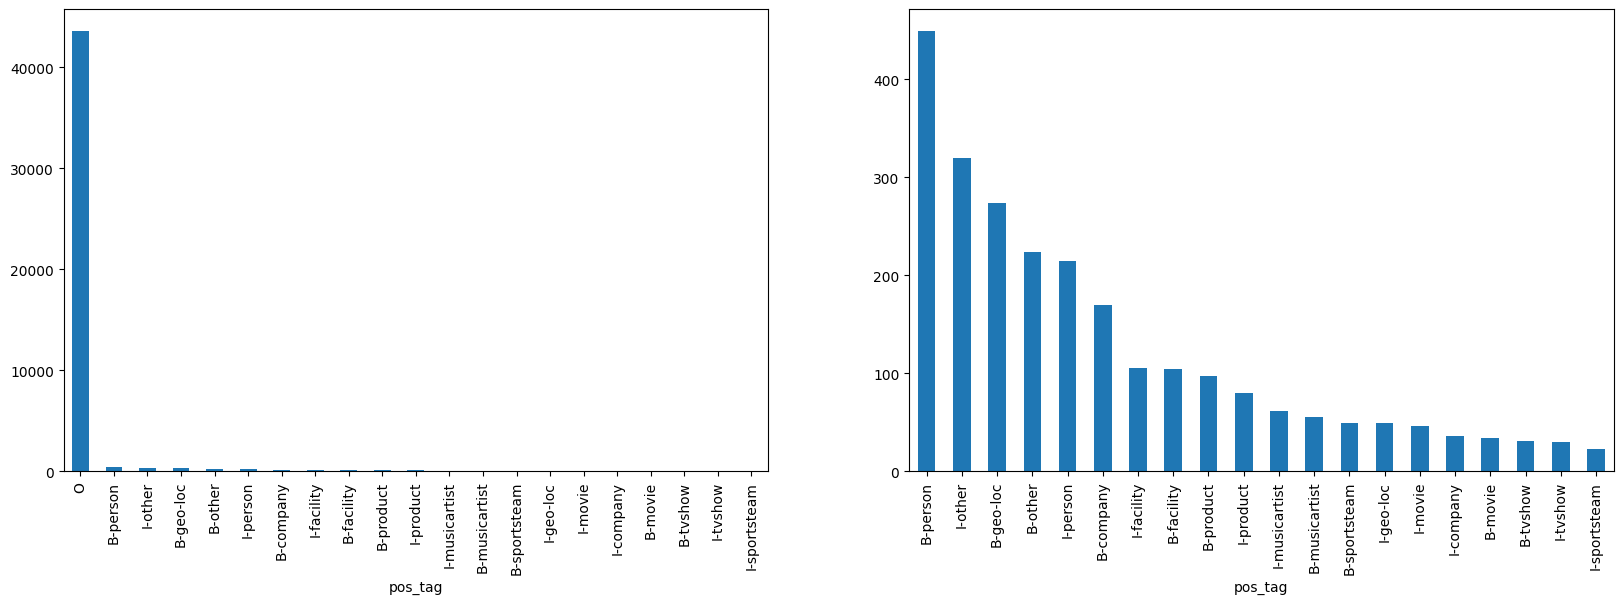

In [ ]:
# Displaying the frequency of the pos_tags in the twitter dataset.
fig, ax = plt.subplots(1,2,figsize=(20, 6))
df['pos_tag'].value_counts().plot(kind='bar', ax=ax[0])

df[df['pos_tag'] != 'O']['pos_tag'].value_counts().plot(kind='bar', ax=ax[1])

plt.show()

Left Plot: Overall POS/NER Tag Distribution

The left plot highlights a strong class imbalance in the dataset, with the “O” (non-entity) tag overwhelmingly dominating the label distribution. This reflects the natural structure of Twitter data, where most tokens do not correspond to named entities. Such imbalance presents a modeling challenge, particularly for sequence labeling tasks, and emphasizes the need for models that can effectively learn contextual patterns to accurately detect relatively rare entity tokens within predominantly non-entity text.

Right Plot: Named Entity Tag Distribution (Excluding “O”)

The right plot focuses exclusively on entity-specific tags, revealing a long-tailed distribution across categories such as persons, locations, organizations, and products. Person-related entities appear most frequently, while categories like movies, TV shows, and sports teams are comparatively sparse. This uneven distribution underlines the importance of robust contextual modeling, as models must generalize well across both high-frequency and low-frequency entity classes to deliver reliable Named Entity Recognition performance.

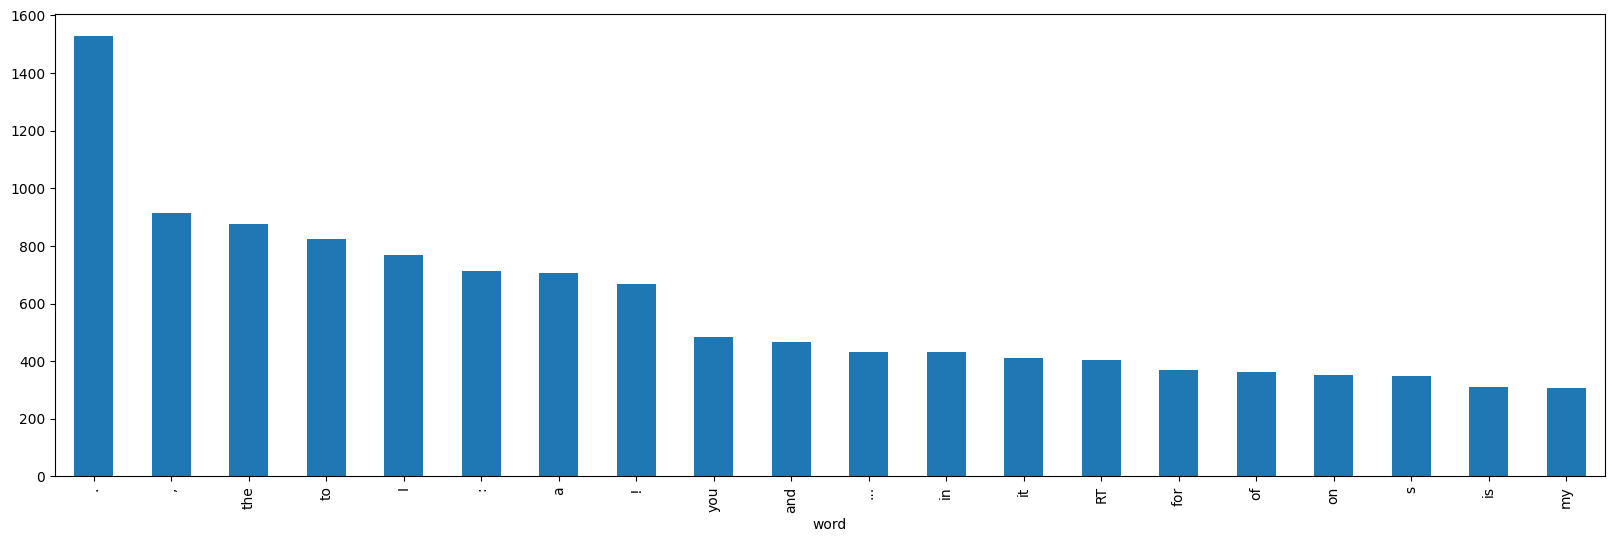

In [ ]:
# Displaying the frequency of overall wordcounts in the twitter dataset.
plt.figure(figsize=(20, 6))
df['word'].value_counts().head(20).plot(kind='bar')
plt.show()

The chart illustrates the most frequently occurring tokens in the Twitter dataset, dominated by common punctuation, stopwords, and platform-specific terms such as “RT”, reflecting the informal and conversational nature of tweets. This distribution highlights the high level of linguistic noise inherent in social media text, where a small set of tokens appears disproportionately often. From a modeling perspective, this reinforces the importance of context-aware approaches, as Named Entity Recognition models must learn to distinguish meaningful entity mentions from frequent but semantically uninformative tokens.

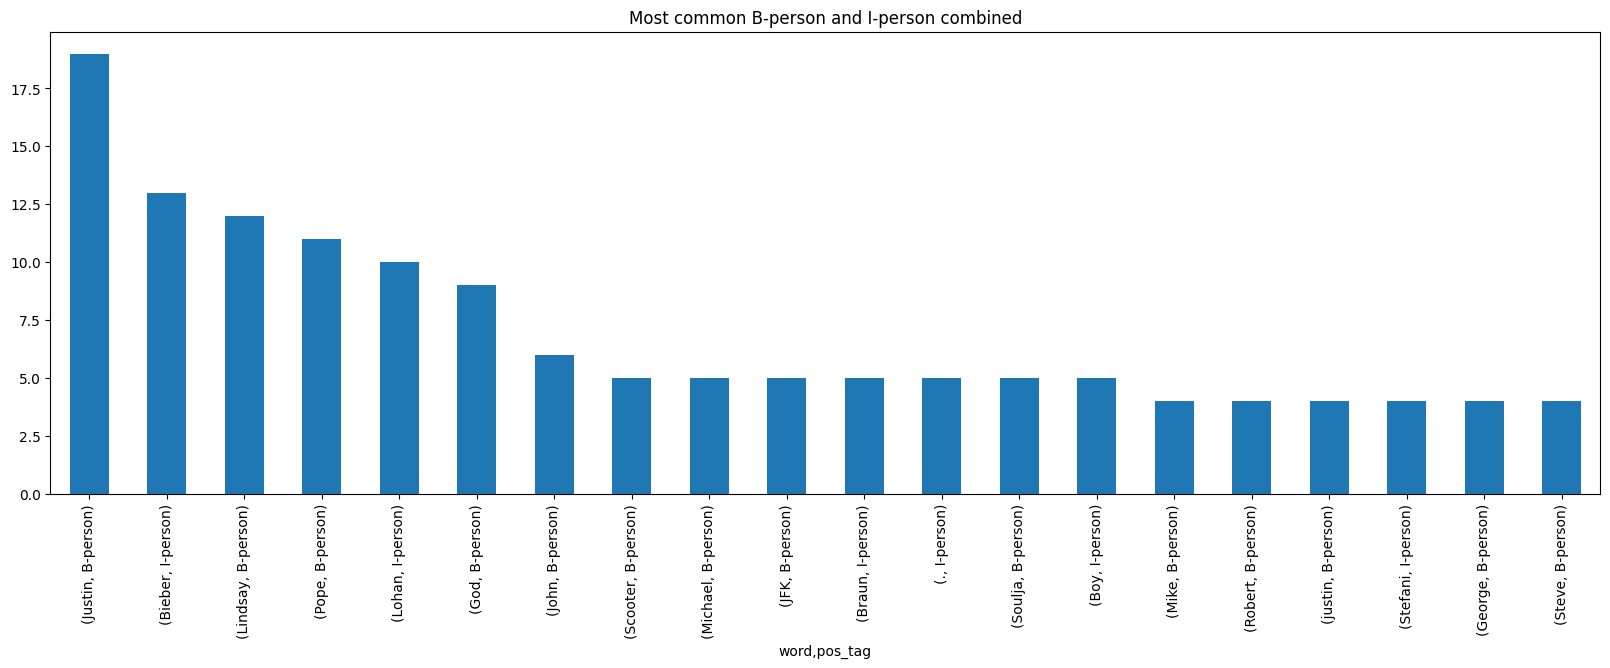

In [ ]:
# Displaying the frequency of most common B-person and I-person combined
plt.figure(figsize=(20, 6))
df[(df['pos_tag'] == 'I-person') | (df['pos_tag'] == 'B-person')].value_counts().head(20).plot(kind='bar')
plt.title('Most common B-person and I-person combined')
plt.show()

The chart highlights the most frequently identified person entities in the Twitter dataset, combining both B-PERSON and I-PERSON tags to reflect complete entity mentions. A small number of names appear repeatedly, indicating that Twitter conversations often concentrate around well-known public figures (like Justin Bieber, Lindsay Lohan and so on), celebrities, and influential individuals. This pattern demonstrates the value of Named Entity Recognition in uncovering who drives discussions and attention on the platform, enabling deeper analysis of influence, trending personalities, and user engagement dynamics.

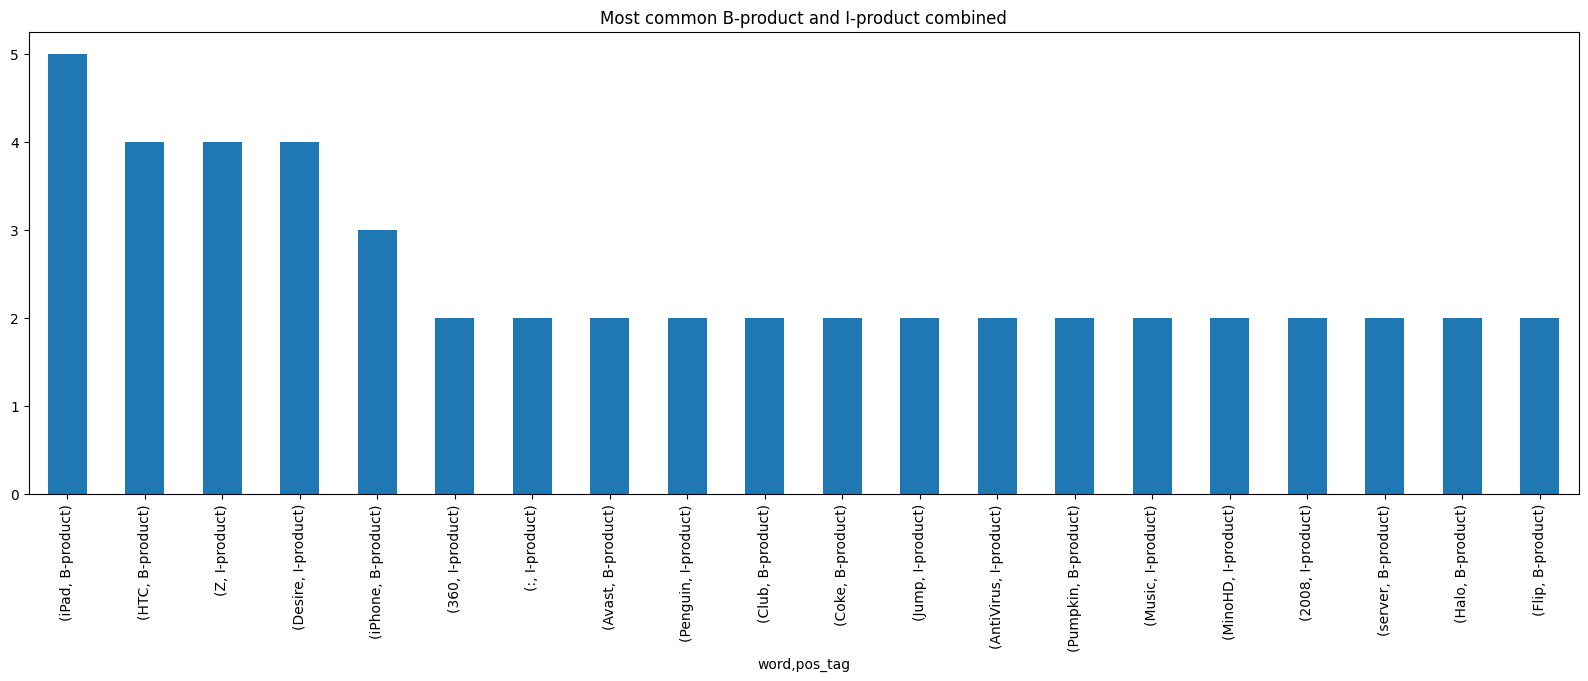

In [ ]:
# Displaying the frequency of most common B-product and I-product combined
plt.figure(figsize=(20, 6))
df[(df['pos_tag'] == 'I-product') | (df['pos_tag'] == 'B-product')].value_counts().head(20).plot(kind='bar')
plt.title('Most common B-product and I-product combined')
plt.show()

The chart highlights the most frequently mentioned product entities in Twitter conversations, with recognizable consumer products such as iPhone, iPad, HTC, and other branded devices appearing most often. While these well-known products stand out, the overall distribution remains sparse and long-tailed, indicating that product mentions occur far less frequently than person or location entities. This reflects typical Twitter usage, where users primarily discuss people and events, with product references appearing selectively. From a business perspective, this underscores the value of an accurate NER system to reliably capture high-impact but low-frequency product mentions, supporting use cases such as brand monitoring, consumer sentiment analysis, and competitive intelligence.

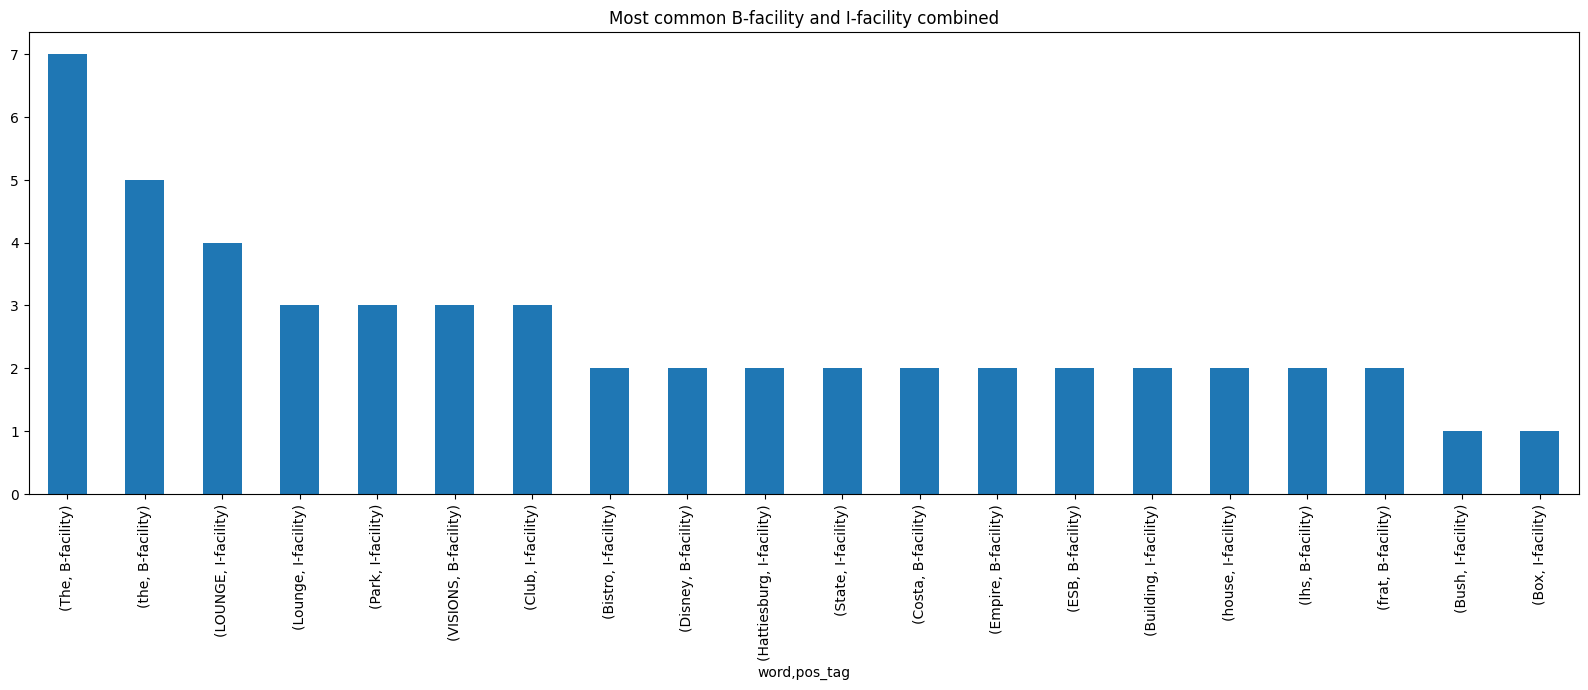

In [ ]:
# Displaying the frequency of most common B-facility and I-facility combined
plt.figure(figsize=(20, 6))
df[(df['pos_tag'] == 'I-facility') | (df['pos_tag'] == 'B-facility')].value_counts().head(20).plot(kind='bar')
plt.title('Most common B-facility and I-facility combined')
plt.show()

The chart illustrates the most frequently mentioned facility-related entities in the Twitter dataset, combining B-FACILITY and I-FACILITY tags to represent complete facility mentions. Common references include general public spaces and establishments such as lounges, parks, clubs, buildings, and venues, while specific facility names appear less frequently. This distribution reflects the informal and conversational nature of Twitter, where location and facility mentions are often broad rather than precise. From a modeling and business perspective, this highlights the importance of accurate NER to identify contextual place references that support applications such as location-based trend analysis, event detection, and user activity insights.

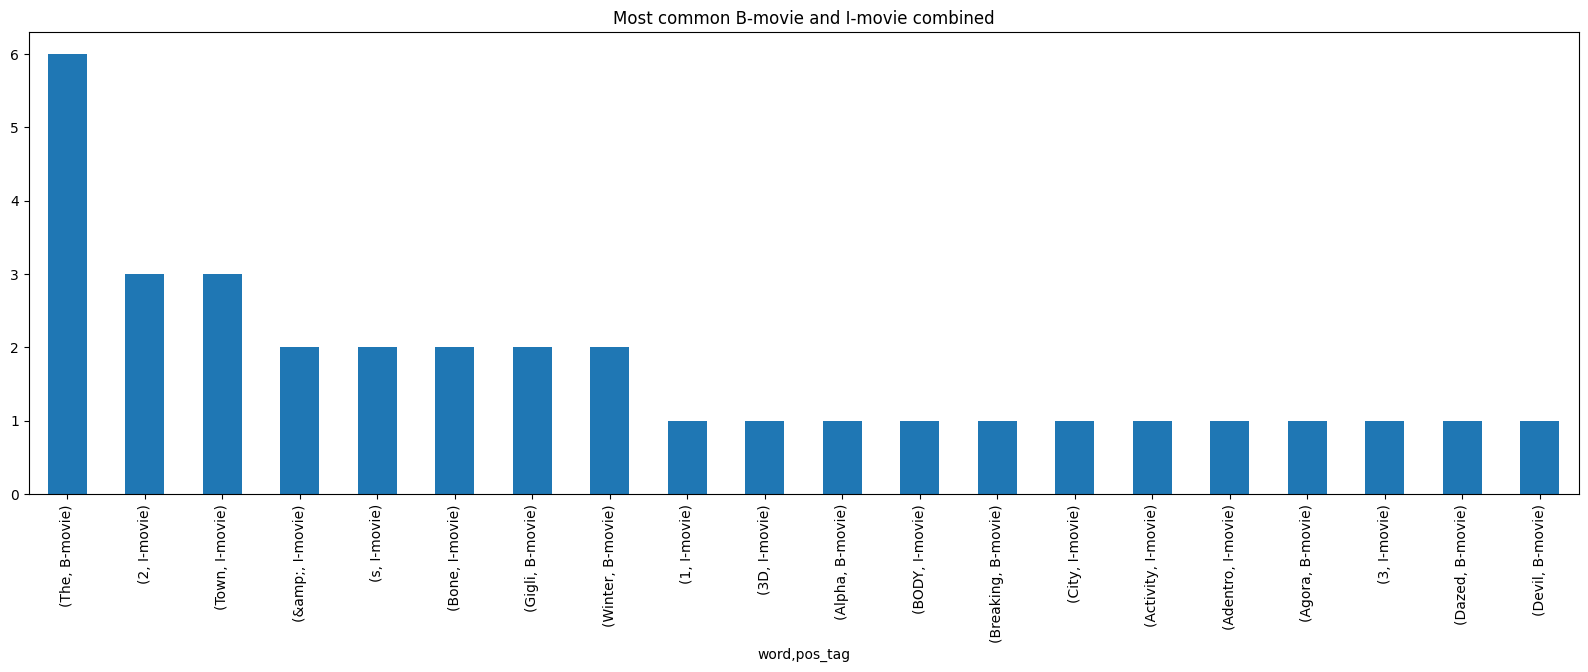

In [ ]:
# Displaying the frequency of most common B-movie and I-movie combined
plt.figure(figsize=(20, 6))
df[(df['pos_tag'] == 'I-movie') | (df['pos_tag'] == 'B-movie')].value_counts().head(20).plot(kind='bar')
plt.title('Most common B-movie and I-movie combined')
plt.show()

The chart shows the most frequently mentioned movie-related entities in the Twitter dataset, combining B-MOVIE and I-MOVIE tags to represent complete movie titles. Movie mentions are relatively sparse and highly fragmented, with only a small number of titles appearing more than once, reflecting the diverse and informal way users reference films on Twitter. This long-tail distribution highlights the challenge of accurately detecting entertainment-related entities in social media text and reinforces the need for context-aware NER models to reliably identify low-frequency but culturally relevant movie mentions for trend and sentiment analysis.

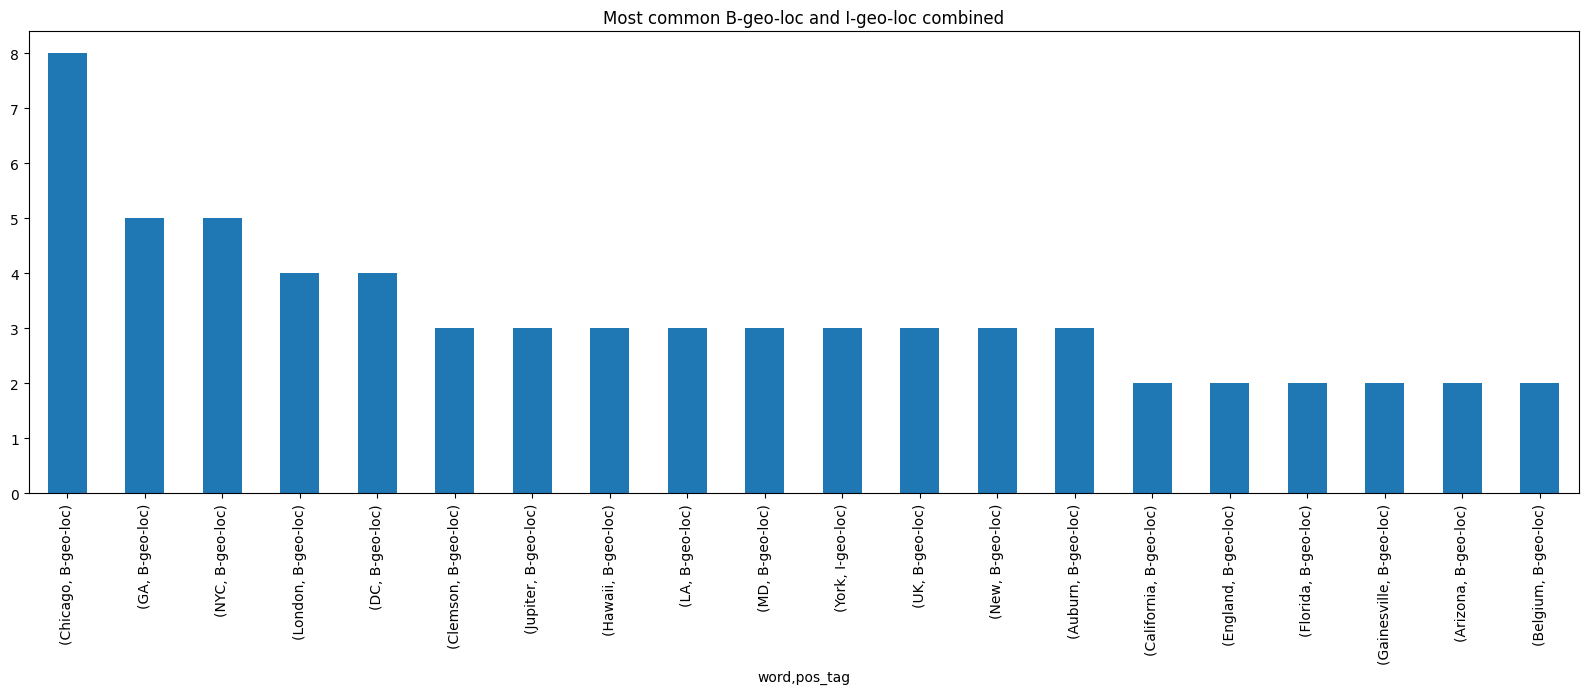

In [ ]:
# Displaying the frequency of most common B-geo-loc and I-geo-loc combined
plt.figure(figsize=(20, 6))
df[(df['pos_tag'] == 'B-geo-loc') | (df['pos_tag'] == 'I-geo-loc')].value_counts().head(20).plot(kind='bar')
plt.title('Most common B-geo-loc and I-geo-loc combined')
plt.show()

The chart displays the most frequently mentioned geographic location entities in the Twitter dataset, combining B-GEO-LOC and I-GEO-LOC tags to represent complete location mentions. References include major cities and regions such as Chicago, New York City, London, Washington D.C., and California, indicating that user conversations often center around prominent urban and regional locations. The distribution is moderately long-tailed, reflecting diverse geographic references across tweets. From a business perspective, accurate identification of location entities enables location-aware trend analysis, regional sentiment tracking, and event monitoring, all of which are critical for understanding geographically driven conversations on the platform.

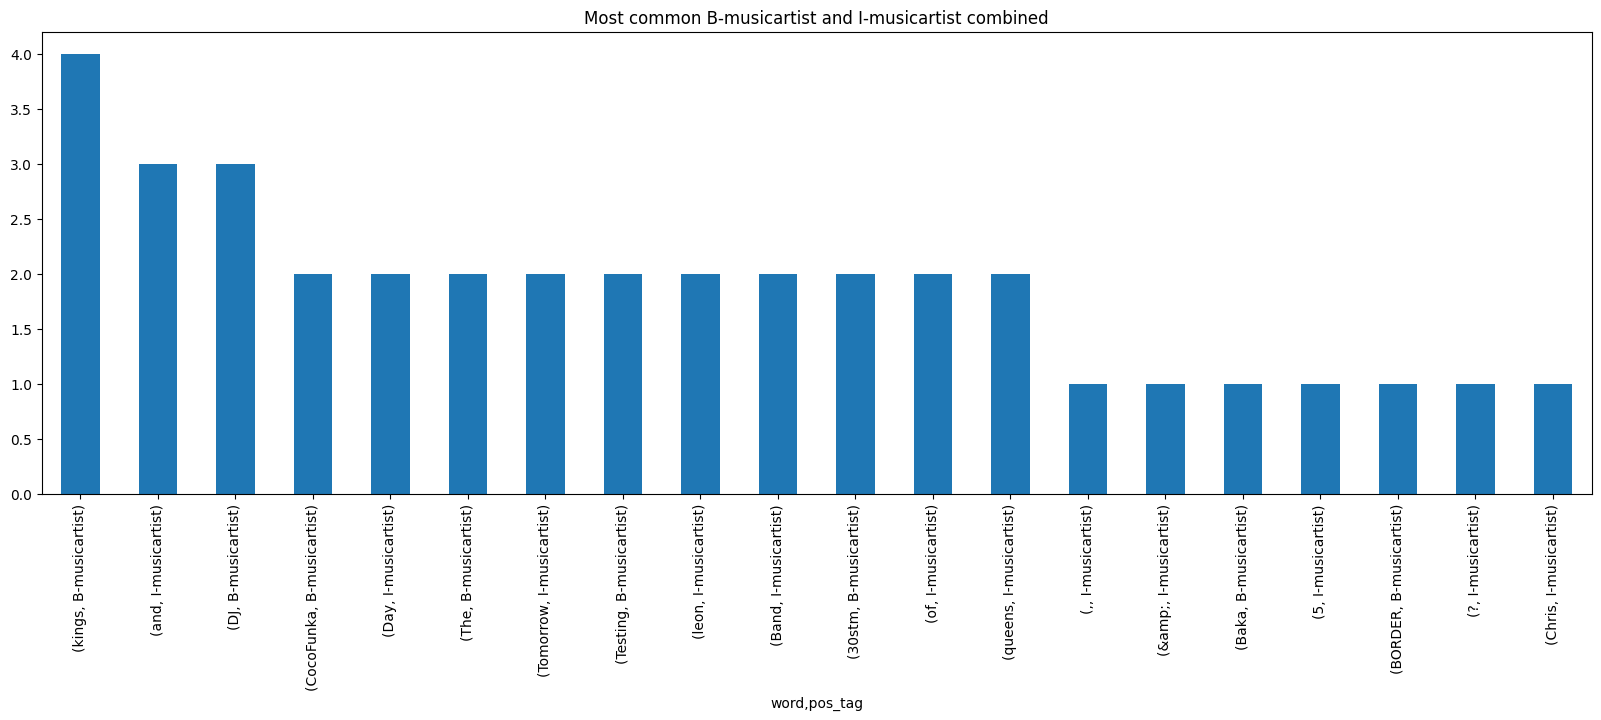

In [ ]:
# Displaying the frequency of most common B-musicartist and I-musicartist combined
plt.figure(figsize=(20, 6))
df[(df['pos_tag'] == 'B-musicartist') | (df['pos_tag'] == 'I-musicartist')].value_counts().head(20).plot(kind='bar')
plt.title('Most common B-musicartist and I-musicartist combined')
plt.show()

The chart shows the most frequently mentioned music artist entities in the Twitter dataset, combining B-MUSICARTIST and I-MUSICARTIST tags to represent complete artist mentions. Artist references are relatively infrequent and widely distributed, with no single artist dominating the conversation, reflecting the diverse and niche nature of music-related discussions on Twitter. This long-tail pattern highlights the challenge of identifying entertainment entities in short, informal text and underscores the importance of robust NER models to accurately capture low-frequency but culturally relevant artist mentions for trend analysis, audience insights, and content categorization.

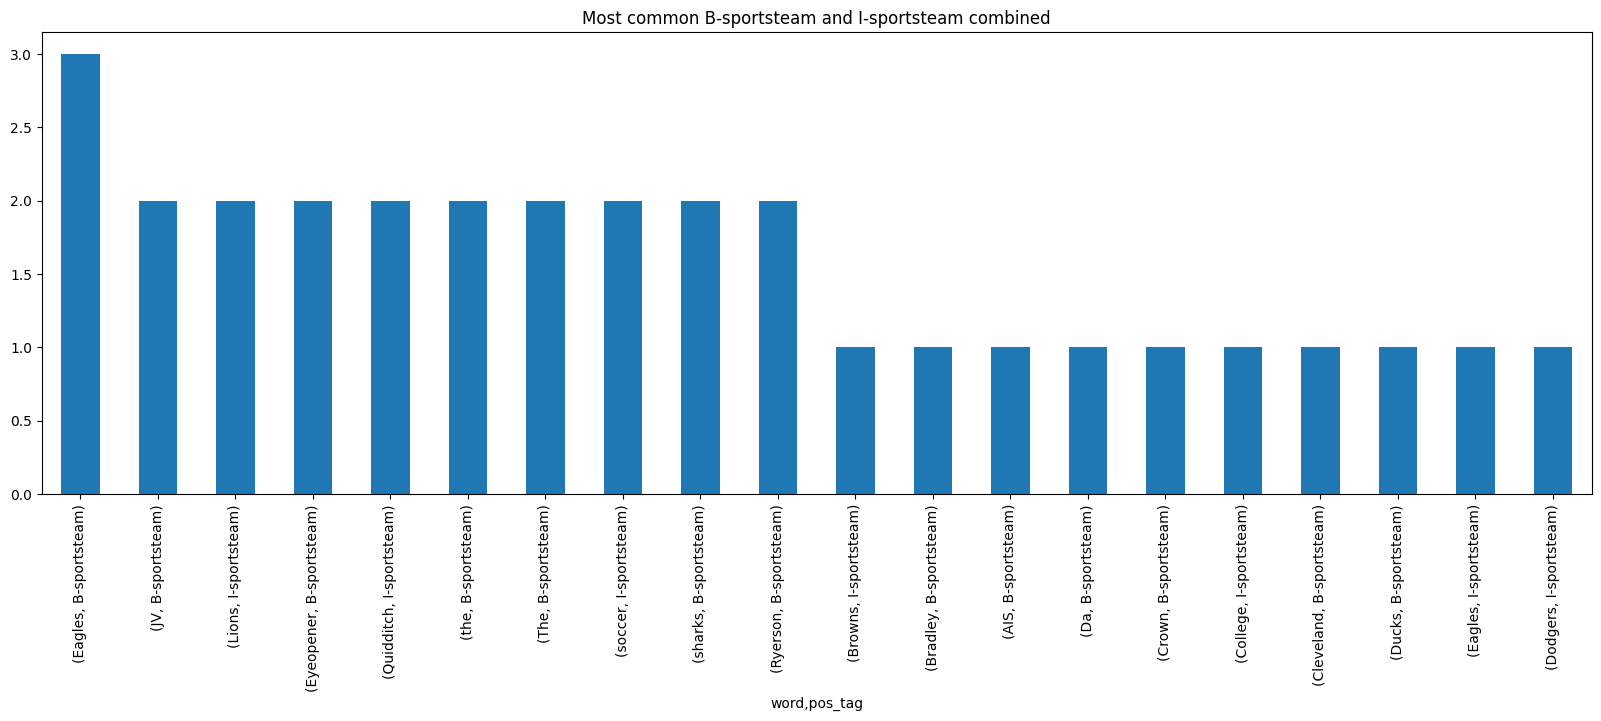

In [ ]:
# Displaying the frequency of most common B-sportsteam and I-sportsteam combined
plt.figure(figsize=(20, 6))
df[(df['pos_tag'] == 'B-sportsteam') | (df['pos_tag'] == 'I-sportsteam')].value_counts().head(20).plot(kind='bar')
plt.title('Most common B-sportsteam and I-sportsteam combined')
plt.show()

The chart presents the most frequently mentioned sports team entities in the Twitter dataset, combining B-SPORTSTEAM and I-SPORTSTEAM tags to represent complete team mentions. Mentions of sports teams are relatively sparse and evenly distributed, with no single team dominating the conversation, reflecting the diverse and event-driven nature of sports-related discussions on Twitter. This distribution highlights the challenge of detecting low-frequency but high-interest entities and underscores the value of accurate NER for enabling sports trend analysis, fan engagement insights, and real-time event monitoring.

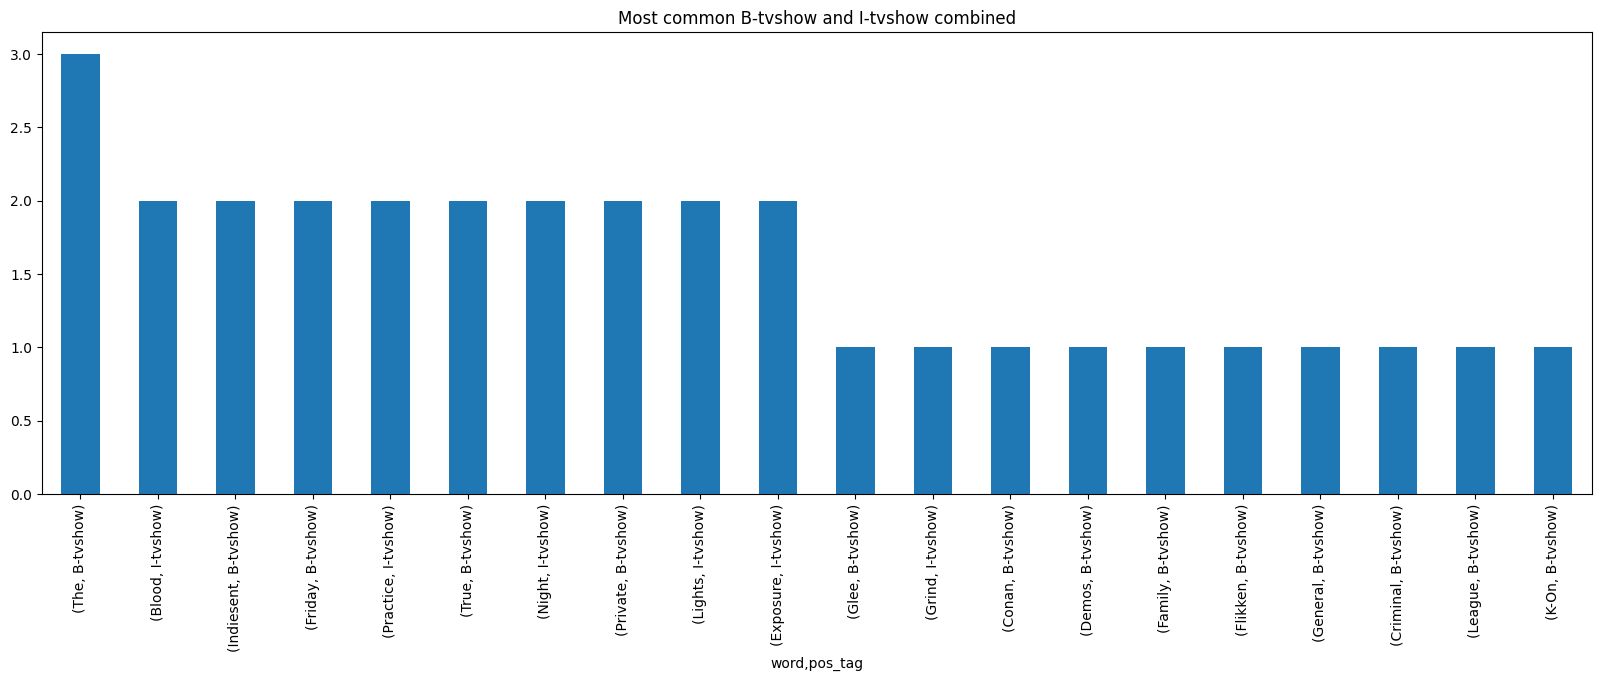

In [ ]:
# Displaying the frequency of most common B-tvshow and I-tvshow combined
plt.figure(figsize=(20, 6))
df[(df['pos_tag'] == 'B-tvshow') | (df['pos_tag'] == 'I-tvshow')].value_counts().head(20).plot(kind='bar')
plt.title('Most common B-tvshow and I-tvshow combined')
plt.show()

The chart illustrates the most frequently mentioned TV show entities in the Twitter dataset, combining B-TVSHOW and I-TVSHOW tags to capture complete show references. TV show mentions are low in frequency and evenly distributed, with no single show dominating the discussion, reflecting the fragmented and diverse nature of entertainment conversations on Twitter. This long-tail distribution highlights the importance of robust Named Entity Recognition models to accurately identify sporadic but high-value TV show mentions, supporting applications such as content categorization, trend discovery, and audience interest analysis.

<H1><font color="lightgreen">Data Preprocessing</font></H1>

In [ ]:
# Defining a class that returns the sentence as a list of sets
class SentenceGetter:
    """
    Returns sentences in the format:
    [(word_1, pos_tag_1), ..., (word_n, pos_tag_n)]
    """

    def __init__(self, file_data):
        """
        Args:
            file_data: List of sentences (output of read_conll_file)
        """
        self.sentences = [
            [(token["word"], token["pos_tag"]) for token in sentence]
            for sentence in file_data
        ]
        self.index = 0

    def get_next(self):
        """Return the next sentence"""
        if self.index < len(self.sentences):
            sentence = self.sentences[self.index]
            self.index += 1
            return sentence
        return None

In [ ]:
# Calling the function Sentencegetter and displaying how a sentence looks like after converting it into list of sets
getter = SentenceGetter(file_data)

sent = getter.get_next()
print("This is what a sentence looks like:")
print(sent)

This is what a sentence looks like:
[('@SammieLynnsMom', 'O'), ('@tg10781', 'O'), ('they', 'O'), ('will', 'O'), ('be', 'O'), ('all', 'O'), ('done', 'O'), ('by', 'O'), ('Sunday', 'O'), ('trust', 'O'), ('me', 'O'), ('*wink*', 'O')]


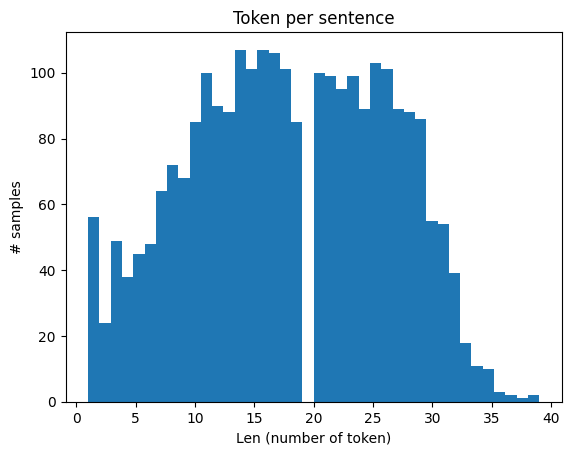

In [ ]:
# Display all the sentence tokens
# Get all the sentences
sentences = getter.sentences
# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=40)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# A function converts raw text and labels into numerical vocabularies that a deep learning model (like BiLSTM + Softmax) can understand.
def build_vocabularies(df):
    """
    Build word and tag vocabularies from a training DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with columns ['word', 'pos_tag']

    Returns:
        word2idx, idx2word, tag2idx, idx2tag
    """

    # ---- Word vocabulary ----
    word2idx = {w: i + 2 for i, w in enumerate(df["word"].unique())}
    word2idx["PAD"] = 0
    word2idx["UNK"] = 1

    idx2word = {i: w for w, i in word2idx.items()}

    # ---- Tag vocabulary ----
    unique_tags = df["pos_tag"].unique()
    tag2idx = {tag: i + 1 for i, tag in enumerate(unique_tags)}
    tag2idx["PAD"] = 0

    idx2tag = {i: tag for tag, i in tag2idx.items()}

    return word2idx, idx2word, tag2idx, idx2tag

In [ ]:
# Calling the build_vocabulary function
word2idx, idx2word, tag2idx, idx2tag = build_vocabularies(df)

print(f"The word 'town' is identified by index: {word2idx.get('town', word2idx['UNK'])}")
print(f"The tag 'B-geo-loc' is identified by index: {tag2idx['B-geo-loc']}")

The word 'town' is identified by index: 1412
The tag 'B-geo-loc' is identified by index: 2


In [ ]:
# Installing the keras_preprocessing library
!pip install keras_preprocessing

In [ ]:
# A function that returns unique number of labels
def get_num_tags(df, tag_column="pos_tag"):
    """
    Calculate the number of unique NER tags in the dataset.

    Args:
        df (pd.DataFrame): Input DataFrame containing NER annotations
        tag_column (str): Column name containing tags (default: 'pos_tag')

    Returns:
        int: Number of unique tags
    """
    return df[tag_column].nunique()

In [ ]:
# Calling the function get_num_tags
n_tags = get_num_tags(df)
print("Number of Labels:", n_tags)

Number of Labels: 21


In [ ]:
# A function to convert tokenized sentences into padded sequences of word indices.
def encode_and_pad_words(
    sentences,
    word2idx,
    max_len,
    pad_token="PAD",
    unk_token="UNK"
):
    """
    Convert tokenized sentences into padded sequences of word indices.

    Args:
        sentences (list): List of sentences, where each sentence is a list of tuples
                          like (word, tag) or (word, pos_tag).
        word2idx (dict): Mapping from word to index.
        max_len (int): Maximum sentence length.
        pad_token (str): Padding token key in word2idx.
        unk_token (str): Unknown token key in word2idx.

    Returns:
        np.ndarray: Padded array of word indices (dtype=int32).
    """

    # Convert words to indices
    X = [
    [
        word2idx.get(
            w[0] if isinstance(w, tuple) else w,
            word2idx[unk_token]
        )
        for w in sentence
    ]
    for sentence in sentences
  ]

    # Pad sequences
    X = pad_sequences(
    X,
    maxlen=max_len,
    padding="post",
    value=word2idx[pad_token],
    dtype="int32"
    )

    return X

In [ ]:
# Calling the function encode_and_pad_words while assigning the results to the variable X
X = encode_and_pad_words(
    sentences=sentences,
    word2idx=word2idx,
    max_len=MAX_LEN
)

print(X.shape, X.dtype)

(2578, 75) int32


In [ ]:
# A function to convert BIO tag sequences into padded sequences of tag indices.
def encode_and_pad_tags(
    sentences,
    tag2idx,
    max_len,
    pad_token="PAD"
):
    """
    Convert BIO tag sequences into padded sequences of tag indices.

    Args:
        sentences (list): List of sentences, where each sentence is a list of tuples
                          like (word, tag).
        tag2idx (dict): Mapping from tag to index.
        max_len (int): Maximum sentence length.
        pad_token (str): Padding token key in tag2idx.

    Returns:
        np.ndarray: Padded array of tag indices (dtype=int32).
    """

    # Convert BIO tags to indices
    y = [
    [
        tag2idx[w[1]] if isinstance(w, tuple) else tag2idx["O"]
        for w in sentence
    ]
    for sentence in sentences
  ]

    # Pad tag sequences
    y = pad_sequences(
    y,
    maxlen=max_len,
    padding="post",
    value=tag2idx[pad_token],
    dtype="int32"
    )

    return y

In [ ]:
# Calling the function encode_and_pad_tags while assigning the results to the variable y
y = encode_and_pad_tags(
    sentences=sentences,
    tag2idx=tag2idx,
    max_len=MAX_LEN
)

print(y.shape, y.dtype)

(2578, 75) int32


In [ ]:
# For a single sentence, we are displaying the sample encoded sentences and encoded tags
print("Sample sentence:")
print(" ".join([w[0] for w in sentences[0]]))

print("\nSample labels:")
print(" ".join([w[1] for w in sentences[0]]))

print("\nEncoded sentence:")
print(X[0])

print("\nEncoded labels:")
print(y[0])

print("\nDtypes:")
print(X.dtype, y.dtype)

Sample sentence:
@SammieLynnsMom @tg10781 they will be all done by Sunday trust me *wink*

Sample labels:
O O O O O O O O O O O O

Encoded sentence:
[ 2  3  4  5  6  7  8  9 10 11 12 13  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]

Encoded labels:
[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]

Dtypes:
int32 int32


In [ ]:
# train-test split
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)

print(X_tr.shape, X_val.shape)
print(y_tr.shape, y_val.shape)

(2320, 75) (258, 75)
(2320, 75) (258, 75)


<H1><font color="lightgreen">Model Building</font></H1>

In [ ]:
!pip install keras-nlp keras-core

In [ ]:
# Defining num_tags, vocab_size and max_len
num_tags = len(tag2idx) # Assigning num_tags - length of pos_tag
vocab_size = len(word2idx) # Assigning vocab_size - length of words
max_len = 75 # Assigning the max_len to be 75

In [ ]:
# Implementing BiLSTM + Softmax architecture

inputs = keras.Input(shape=(max_len,), dtype="int32")

# Embedding
x = keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=128,
    mask_zero=True
)(inputs)

# BiLSTM
x = keras.layers.Bidirectional(
    keras.layers.LSTM(64, return_sequences=True)
)(x)

# Token-level classification (Softmax)
outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(num_tags, activation="softmax")
)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compiling the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# model summary
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 75)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 75, 128)   │  1,298,176 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_8         │ (None, 75)        │          0 │ input_layer_8[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 75, 128)   │     98,816 │ embedding_8[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 75, 22)    │      2,838 │ bidirectional_8[… │
│ (TimeDistributed)   │                   │            │ not_equal_8[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,399,830 (5.34 MB)

 Trainable params: 1,399,830 (5.34 MB)

 Non-trainable params: 0 (0.00 B)

The model employs a BiLSTM-based sequence labeling architecture designed for Named Entity Recognition on Twitter text. An embedding layer transforms input tokens into dense vector representations, which are then processed by a bidirectional LSTM to capture contextual information from both past and future tokens. The final TimeDistributed Softmax layer predicts a label for each token in the sequence. With approximately 1.4 million trainable parameters, the model balances representational capacity and computational efficiency, making it suitable as a strong baseline for comparison against transformer-based models such as BERT.

In [ ]:
# fitting the model
history = model.fit(
    X_tr,
    y_tr,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=5
)

Epoch 1/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 38s 229ms/step - accuracy: 0.2537 - loss: 1.7214 - val_accuracy: 0.2258 - val_loss: 0.4258
Epoch 2/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.2233 - loss: 0.3702 - val_accuracy: 0.2258 - val_loss: 0.3844
Epoch 3/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 0.2274 - loss: 0.2998 - val_accuracy: 0.2258 - val_loss: 0.3408
Epoch 4/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - accuracy: 0.2243 - loss: 0.2271 - val_accuracy: 0.2262 - val_loss: 0.3216
Epoch 5/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 224ms/step - accuracy: 0.2281 - loss: 0.1916 - val_accuracy: 0.2263 - val_loss: 0.3184


In [ ]:
# Predicting the validation set
y_pred_val = model.predict(X_val)
y_val_pred = y_pred_val.argmax(axis=-1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step


In [ ]:
# Convert padded tag index sequences into BIO tag strings, ignoring PAD tokens for classification report

def decode_tag_sequences(y_true, y_pred, tag2idx, idx2tag):
    """
    Convert padded tag index sequences into BIO tag strings,
    ignoring PAD tokens.

    Args:
        y_true (np.ndarray): True tag indices (num_samples, max_len)
        y_pred (np.ndarray): Predicted tag indices (num_samples, max_len)
        tag2idx (dict): Mapping from tag string to index
        idx2tag (dict): Mapping from index to tag string

    Returns:
        y_true_labels (list[list[str]]): True BIO tag sequences
        y_pred_labels (list[list[str]]): Predicted BIO tag sequences
    """
    y_true_labels = []
    y_pred_labels = []

    pad_idx = tag2idx["PAD"]

    for true_seq, pred_seq in zip(y_true, y_pred):
        true_tags = []
        pred_tags = []

        for t, p in zip(true_seq, pred_seq):
            if t != pad_idx:
                true_tags.append(idx2tag[t])
                pred_tags.append(idx2tag[p])

        y_true_labels.append(true_tags)
        y_pred_labels.append(pred_tags)

    return y_true_labels, y_pred_labels

In [ ]:
# Calling decode_tag_sequences function and displaying the classification report
y_val_labels, y_val_pred_labels = decode_tag_sequences(
    y_val,
    y_val_pred,
    tag2idx,
    idx2tag
)

print(classification_report(y_val_labels, y_val_pred_labels))
print("F1 Score:", f1_score(y_val_labels, y_val_pred_labels))

              precision    recall  f1-score   support

     company       0.00      0.00      0.00        15
    facility       0.00      0.00      0.00         9
     geo-loc       0.00      0.00      0.00        29
       movie       0.00      0.00      0.00         4
 musicartist       0.00      0.00      0.00         8
       other       0.00      0.00      0.00        27
      person       0.12      0.15      0.13        47
     product       0.00      0.00      0.00        12
  sportsteam       0.00      0.00      0.00         7
      tvshow       0.00      0.00      0.00         3

   micro avg       0.12      0.04      0.06       161
   macro avg       0.01      0.01      0.01       161
weighted avg       0.04      0.04      0.04       161

F1 Score: 0.06392694063926942


**BiLSTM + Softmax validation Performance**

The validation results indicate that the BiLSTM + Softmax baseline model achieves limited performance across most named entity categories, with meaningful predictions primarily observed for person entities, while other classes show near-zero precision and recall. The overall F1 score of approximately 0.06 reflects the impact of strong class imbalance and the model’s inability to explicitly model label dependencies in sequence tagging tasks. These results establish an important baseline, highlighting the challenges of Named Entity Recognition on noisy Twitter data and reinforcing the need for more advanced approaches, such as transformer-based models, to achieve robust and scalable entity extraction.

In [ ]:
# Load test CoNLL file
test_file_data = read_conll_file("/content/wnut 16test.txt.conll")

# Convert to DataFrame (for analysis only)
test_df = conll_to_dataframe(test_file_data)

# Extract sentence structure
test_sentences = SentenceGetter(test_file_data).sentences

x_test = encode_and_pad_words(
    test_sentences,
    word2idx=word2idx,
    max_len=MAX_LEN
)

y_test = encode_and_pad_tags(
    test_sentences,
    tag2idx=tag2idx,
    max_len=MAX_LEN
)

In [ ]:
# Predicting for test set
y_pred_probs = model.predict(x_test)
y_test_pred = y_pred_probs.argmax(axis=-1)

148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step


In [ ]:
# calling decode_tag_sequences and displaying the classification report

y_test_labels, y_test_pred_labels = decode_tag_sequences(
    y_test,
    y_test_pred,
    tag2idx,
    idx2tag
)

print(classification_report(y_test_labels, y_test_pred_labels))
print("F1 Score:", f1_score(y_test_labels, y_test_pred_labels))

              precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
     company       0.00      0.00      0.00       586
    facility       0.00      0.00      0.00       244
     geo-loc       0.25      0.00      0.00       768
       movie       0.00      0.00      0.00        28
 musicartist       0.00      0.00      0.00       180
       other       0.00      0.00      0.00       536
      person       0.02      0.02      0.02       466
     product       0.00      0.00      0.00       216
  sportsteam       0.00      0.00      0.00       128
      tvshow       0.00      0.00      0.00        24

   micro avg       0.02      0.00      0.01      3176
   macro avg       0.02      0.00      0.00      3176
weighted avg       0.06      0.00      0.00      3176

F1 Score: 0.006163328197226502


**BiLSTM + Softmax Test Performance**

The test-set evaluation shows that the BiLSTM + Softmax baseline model struggles to generalize across most named entity categories, achieving a very low overall F1 score of approximately 0.01. Limited predictive capability is observed primarily for person and geographic location entities, while other classes receive negligible precision and recall due to strong class imbalance and the absence of structured label dependency modeling. These results reinforce the role of this architecture as a baseline reference, clearly demonstrating the complexity of Named Entity Recognition on noisy Twitter data and motivating the use of more advanced transformer-based models for production-level performance.

In [ ]:
sample_weights = (y_tr != tag2idx["PAD"]).astype("float32")
val_sample_weights = (y_val != tag2idx["PAD"]).astype("float32")

In [ ]:
# BiLSTM + Softmax NER model while masking padded tokens using sample weights and applying early stopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_tr,
    y_tr,
    sample_weight=sample_weights,
    validation_data=(X_val, y_val, val_sample_weights),
    batch_size=32,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - accuracy: 0.2296 - loss: 0.1689 - val_accuracy: 0.2261 - val_loss: 0.3204
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step - accuracy: 0.2296 - loss: 0.1512 - val_accuracy: 0.2260 - val_loss: 0.3125
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 15s 203ms/step - accuracy: 0.2305 - loss: 0.1486 - val_accuracy: 0.2260 - val_loss: 0.3365
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.2310 - loss: 0.1383 - val_accuracy: 0.2259 - val_loss: 0.3371
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.2254 - loss: 0.1294 - val_accuracy: 0.2260 - val_loss: 0.3459
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.2297 - loss: 0.1192 - val_accuracy: 0.2260 - val_loss: 0.3385
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 15s 210ms/step - accuracy: 0.2333 - loss: 0.1065 - val_accuracy: 0.2253 - val_loss: 0.3401


In [ ]:
# Predicting the test dataframe
y_test_pred_probs = model.predict(x_test)
y_test_pred = y_test_pred_probs.argmax(axis=-1)

148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step


In [ ]:
# calling the decode_tag_sequences and displaying the classification report
y_test_labels, y_test_pred_labels = decode_tag_sequences(
    y_test,
    y_test_pred,
    tag2idx,
    idx2tag
)

print(classification_report(y_test_labels, y_test_pred_labels))
print("F1 Score:", f1_score(y_test_labels, y_test_pred_labels))

              precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
     company       0.00      0.00      0.00       586
    facility       0.00      0.00      0.00       244
     geo-loc       0.18      0.01      0.01       768
       movie       0.00      0.00      0.00        28
 musicartist       0.00      0.00      0.00       180
       other       0.00      0.00      0.00       536
      person       0.03      0.06      0.04       466
     product       0.00      0.00      0.00       216
  sportsteam       0.00      0.00      0.00       128
      tvshow       0.00      0.00      0.00        24

   micro avg       0.03      0.01      0.02      3176
   macro avg       0.02      0.01      0.00      3176
weighted avg       0.05      0.01      0.01      3176

F1 Score: 0.015013648771610552


The results demonstrate that the BiLSTM + Softmax baseline model, even with padded-token masking and early stopping, achieves very limited performance on the test dataset, with an overall F1 score of approximately 0.02. The model shows minimal predictive capability for geographic location and person entities, while most other entity categories receive near-zero precision and recall, largely due to severe class imbalance and the independent token-level predictions imposed by the Softmax layer. These findings confirm that while the model serves as a valid baseline, it lacks the representational power required for robust Named Entity Recognition on noisy, real-world Twitter data, thereby motivating the adoption of more advanced transformer-based architectures.

In [ ]:
# Define the input layer
# Each input is a sequence of word indices with fixed length MAX_LEN
inputs = keras.Input(shape=(MAX_LEN,), dtype="int32")

# Embedding layer
# - Converts word indices into dense 128-dimensional vectors
# - mask_zero=True ensures padded tokens (index 0) are ignored by downstream layers
x = keras.layers.Embedding(
    input_dim=vocab_size, # Vocabulary size
    output_dim=128, # Dimension of word embeddings
    mask_zero=True # Mask padding tokens
)(inputs)

# Bidirectional LSTM layer
# - Captures both past (left context) and future (right context) information
# - return_sequences=True ensures an output for every time step (required for NER)
# - dropout and recurrent_dropout help reduce overfitting
x = keras.layers.Bidirectional(
    keras.layers.LSTM(
        64, # Number of LSTM units
        return_sequences=True, # Required for sequence labeling
        dropout=0.3, # Dropout on input connections
        recurrent_dropout=0.2 # Dropout on recurrent connections
    )
)(x)

# TimeDistributed Dense layer
# - Applies a Softmax classifier at each time step
# - Outputs probability distribution over NER tags for every token
outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(num_tags, activation="softmax") # Number of NER tag classes and softmax
)(x)

# Build the Keras model
model = keras.Model(inputs, outputs)

# Compile the model
# - Adam optimizer with a small learning rate for stable training
# - Sparse categorical cross-entropy since labels are integer-encoded
# - Accuracy used as a basic training metric
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Summary of the hyperparameter tuned model
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 75)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 75, 128)   │  1,298,176 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_9         │ (None, 75)        │          0 │ input_layer_9[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 75, 128)   │     98,816 │ embedding_9[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 75, 22)    │      2,838 │ bidirectional_9[… │
│ (TimeDistributed)   │                   │            │ not_equal_9[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,399,830 (5.34 MB)

 Trainable params: 1,399,830 (5.34 MB)

 Non-trainable params: 0 (0.00 B)

This architecture represents a hyperparameter-tuned BiLSTM + Softmax NER model designed for token-level entity recognition on Twitter data. Each tweet is processed as a fixed-length sequence of 75 tokens, embedded into dense 128-dimensional vectors, and passed through a Bidirectional LSTM to capture both left and right contextual information. A TimeDistributed Softmax layer then predicts one of 22 NER tags for every token in the sequence. With approximately 1.4 million trainable parameters, the model balances contextual learning capacity and computational efficiency, making it suitable for large-scale, high-velocity text streams such as tweets.

In [ ]:
# fitting the model
history = model.fit(
    X_tr,
    y_tr,
    sample_weight=sample_weights,
    validation_data=(X_val, y_val, val_sample_weights),
    batch_size=32,
    epochs=5)

Epoch 1/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 361ms/step - accuracy: 0.2296 - loss: 2.6791 - val_accuracy: 0.2258 - val_loss: 0.5364
Epoch 2/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 24s 326ms/step - accuracy: 0.2232 - loss: 0.4720 - val_accuracy: 0.2258 - val_loss: 0.4669
Epoch 3/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 24s 330ms/step - accuracy: 0.2263 - loss: 0.4066 - val_accuracy: 0.2258 - val_loss: 0.4390
Epoch 4/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 24s 327ms/step - accuracy: 0.2250 - loss: 0.3711 - val_accuracy: 0.2258 - val_loss: 0.4181
Epoch 5/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 318ms/step - accuracy: 0.2184 - loss: 0.3741 - val_accuracy: 0.2258 - val_loss: 0.4013


In [ ]:
# Predicting the values for x_test
y_test_pred = model.predict(x_test)
y_test_pred = y_test_pred.argmax(axis=-1)

148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step


In [ ]:
# Calling decode_tag_sequences function and displaying the classification report
y_test_labels, y_test_pred_labels = decode_tag_sequences(
    y_test,
    y_test_pred,
    tag2idx,
    idx2tag
)

print(classification_report(y_test_labels, y_test_pred_labels))
print("F1 Score:", f1_score(y_test_labels, y_test_pred_labels))

              precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
     company       0.00      0.00      0.00       586
    facility       0.00      0.00      0.00       244
     geo-loc       0.00      0.00      0.00       768
       movie       0.00      0.00      0.00        28
 musicartist       0.00      0.00      0.00       180
       other       0.00      0.00      0.00       536
      person       0.00      0.00      0.00       466
     product       0.00      0.00      0.00       216
  sportsteam       0.00      0.00      0.00       128
      tvshow       0.00      0.00      0.00        24

   micro avg       0.00      0.00      0.00      3176
   macro avg       0.00      0.00      0.00      3176
weighted avg       0.00      0.00      0.00      3176

F1 Score: 0.0


The evaluation results indicate that the hyperparameter-tuned BiLSTM + Softmax model failed to generalize on the test set, achieving an overall F1 score of 0.0 across all named entity categories. Despite the presence of substantial ground-truth entities (e.g., geo-location, company, person), the model did not correctly identify any entity instances, resulting in zero precision and recall for every class. This suggests that the model has likely collapsed to predicting only the non-entity (O) class during inference, highlighting limitations of the BiLSTM + Softmax approach on highly imbalanced, short-text data such as tweets. From a business perspective, this reinforces the need for more robust sequence modeling techniques (e.g., CRF decoding or Transformer-based models) and improved handling of class imbalance to achieve reliable entity extraction at scale.